# Functions for DEM differencing and estimating uncertainty volume calculations 

This repository contains functions to conduct DEM differencing and to help in estimating uncertainty in volumetric calculations.  The functions in `DEM_differencing_functions.py` can be used to prepare DEMs (align, clip, and co-register), difference them, and assess the vertical agreement between the input data sets by examining the DEMs of difference in polygons defining stable areas.  The results of the stable area analysis can then be used as inputs to estimate uncertainty in the volumetric calculations using the `VolumetricUncertaintyCalculations.ipynb` notebook. All rasters must be in GeoTIFF format, and all polygon vectors must be in ESRI shapefile format.

Some key functions included are:
- `integer_align_raster`: Align raster to integer bounds. Used to ensure coincident raster alignment before DEM differencing.
- `integer_align_resample_raster_bilinear`: Align raster to integer bounds and resample to new cell size. 
- `resample_raster_bilinear`: Resample raster to new cell size.
- `create_polygon_from_points`: Create shapefile from csv of points.  Used to create clipping mask from x,y locations of measurements (for instance bathymetry points)
- `clip_raster`: Clip a raster using a polygon shapefile
- `raster_outline_to_polyshp`: Create a polygon shapefile from raster footprint.
- `vertical_adjust_raster`: Adjust raster up or down. Used for co-registration before differencing.
- `DEM_difference`: Difference two DEMs to create a DoD (DEM of difference)
- `calculate_volume`: Calulate the volume of a DoD
- `stable_area_stats`: Conduct zonal statistics on a DoD using polygons, and optionally write statistics to shapefile attribute table. Used to assess DoD in stable areas, for uncertainty calculations.
- `SpatiallyCorrelatedRandomErrorAnalysis*` functions:  Functions to help create spatial semivariogram to help estimate spatially correlated random error.
    - `SpatiallyCorrelatedRandomErrorAnalysis_DataPrep`: Prepare data to create spatial semivariogram to help estimate spatially correlated random error.  Required before other `SpatiallyCorrelatedRandomErrorAnalysis*` functions are run.
    - `SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram`: Create spatial semivariogram to help determine approximate `range` size for subsequent semivariograms.
    - `SpatiallyCorrelatedRandomErrorAnalysis_OptimizedModel`: Create spatial semivariogram using autofit to find the optimized model type to minimize RMS and find optimized range size.
    - `SpatiallyCorrelatedRandomErrorAnalysis_FitSphericalModel`: Create spatial semivariogram using spherical model and find best range and sill values.
    - `SpatiallyCorrelatedRandomErrorAnalysis_FitSphericalModel_gstat`: Create spatial semivariogram using spherical model and find best range and sill values using Scikit Gstat library, which may perform better.


### A typical workflow would be as follows: 

In [1]:
from pathlib import Path
import sys
sys.path.append(r'.')
from DEM_differencing_functions import *

##### Align rasters and resample 

In [ ]:
#integer align raster 1
inras1 = Path(r"C:\dem_1_1m.tif")
inras1_aligned = Path(r"C:\dem_1_1m_align.tif")

integer_align_raster(inras1,inras1_aligned)

#integer align raster 2 and resample to 1 m cell size
inras2 = Path(r"C:\dem_2_50cm.tif")
inras2_aligned_resampled = Path(r"C:\dem_2_1m_align.tif")

integer_align_resample_raster_bilinear(inras2, 1, inras2_aligned_resampled)

##### Difference rasters, and create preliminary DOD

In [ ]:
#difference DEMs
inras1_aligned = Path(r"C:\dem_1_1m_align.tif")
inras2_aligned_resampled = Path(r"C:\dem_2_1m_align.tif")
prelim_dod_unclipped = Path(r"C:\prelim_dod_unclipped.tif")

DEM_difference(inras1_aligned, inras2_aligned_resampled, prelim_dod_unclipped)

##### Create polygon shapefile with polygons defining one or more stable areas, and calculate zonal statistics of DoD in these areas

In [ ]:
#Stable area analysis
prelim_dod_unclipped = Path(r"C:\prelim_dod_unclipped.tif")
stable_poly = Path(r"C:\stable_poly.shp")

df = stable_area_stats(prelim_dod_unclipped, stable_poly, add_to_attribute_table=False)

##### If systematic offset present in stable areas, use this value to vertically adjust one of the DEMs to co-register to the other

In [ ]:
#Co-register
inras2_aligned_resampled = Path(r"C:\dem_2_1m_align.tif")
inras2_aligned_resampled_coregistered = Path(r"C:\dem_2_1m_align_coreg.tif")

#For instance, the function below adds 0.281 meters to the input DEM to vertically adjust it upward.
vertical_adjust_raster(inras2_aligned_resampled, 0.281, inras2_aligned_resampled_coregistered)

##### Redo DEM differencing with co-registered DEM.

In [ ]:
#difference co-registered DEMs
inras1_aligned = Path(r"C:\dem_1_1m_align.tif")
inras2_aligned_resampled_coregistered = Path(r"C:\dem_2_1m_align_coreg.tif")
final_dod_unclipped = Path(r"C:\final_dod_unclipped.tif")

DEM_difference(inras1_aligned, inras2_aligned_resampled_coregistered, final_dod_unclipped)

##### Recalculate zonal statistics of new DoD (which should have reduced systematic error).  Use mean (or MAE) and STDev of stable areas (one or more) to estimate uncertainty in volume calculations.

In [ ]:
#Stable area analysis
final_dod_unclipped = Path(r"C:\prelim_dod_unclipped.tif")
stable_poly = Path(r"C:\stable_poly.shp")

df = stable_area_stats(final_dod_unclipped, stable_poly, add_to_attribute_table=False)

##### Clip DoD to final analysis area.

In [ ]:
#Clip to analysis area
final_dod_unclipped = Path(r"C:\final_dod_unclipped.tif")
final_dod_clipped = Path(r"C:\final_dod_clipped.tif")
clip_shp = Path(r"C:\AnalysisArea.shp")

clip_raster(final_dod_unclipped, clip_shp, final_dod_clipped)

##### Prepare data and plot semivariogram to assist with estimating spatially correlated random error in uncertainty analysis.  Use largest available stable area in DoD.

'Warning! Attribute is_variance is set to False but you try to plot this object! Plot has been cancelled.\n'


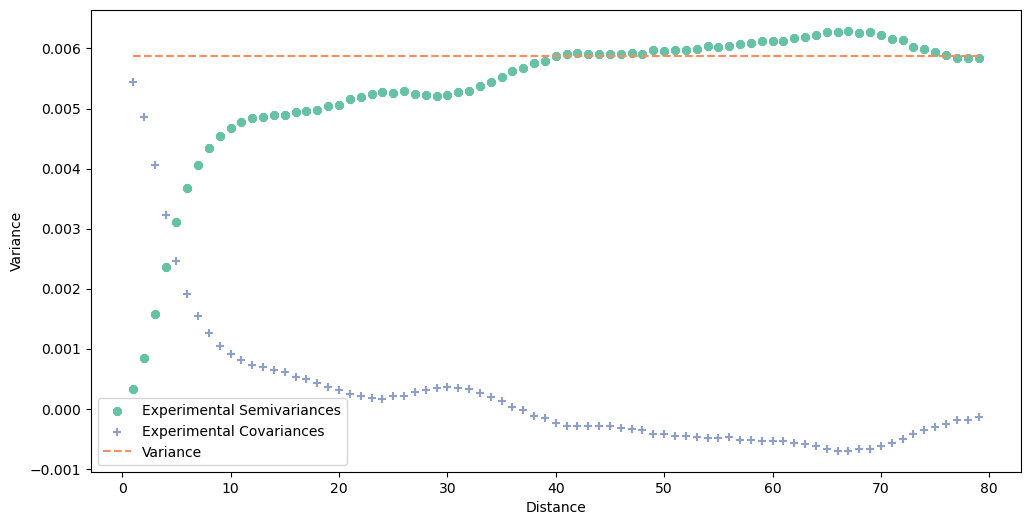

In [3]:
#Prep data, using cells from stable area polygon "id"=1 from stable polygon shapefile
df = SpatiallyCorrelatedRandomErrorAnalysis_DataPrep(final_dod_unclipped, stable_poly, poly_id_field='id', poly_id=1)
#Plot prelim semivariogram, use this to estimate range (reduce range if needed for plotting)
experimental_variogram = SpatiallyCorrelatedRandomErrorAnalysis_CreateSemivariogram(df,1, max_range=80)

##### Use semivariogram plot to estimate `range` parameter for `SpatiallyCorrelatedRandomErrorAnalysis_OptimizedModel` function, below. Use optimized sill and range as inputs for `VolumetricUncertaintyCalculations.ipynb` notebook.



Optimized model type: spherical
Nugget: 0
Optimized Sill: 0.00587096953275412 (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)
Optimized Range: 22.287440409342658 (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)
RMSE: 0.0005039054855293714


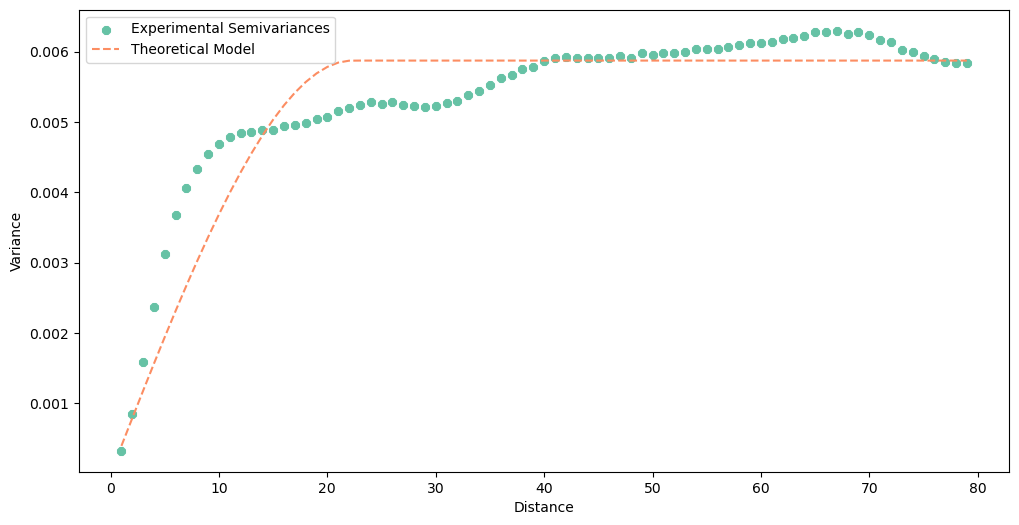

In [4]:
#Use OptimizedModel function to fit best model type and identify range and sill
_ = SpatiallyCorrelatedRandomErrorAnalysis_OptimizedModel(experimental_variogram)



Model type: spherical
Nugget: 0
Optimized Sill: 0.00587096953275412 (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)
Optimized Range: 22.287440409342658 (USE THIS VALUE FOR SPATIALLY CORRELATED RANDOM ERROR VOLUMETRIC UNCERTAINTY CALCULATIONS)
RMSE: 0.0005039054855293714


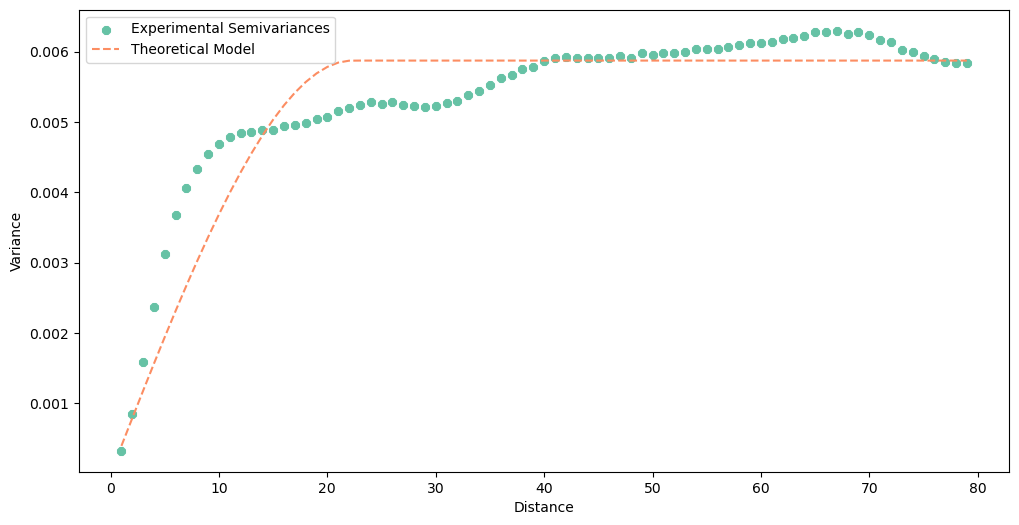

In [5]:
#Or fit a spherical model and find optimize range and sill
_ = SpatiallyCorrelatedRandomErrorAnalysis_FitSphericalModel(experimental_variogram, nugget=0)

##### Use values calculated through stable area analysis to help estimate uncertainty in volumetric calculations using `VolumetricUncertaintyCalculations.ipynb` notebook:

- Use either absolute mean or mean absolute error (MAE) of DoD in stable area (or areas) (derived using `stable_area_stats`) as `sigma_sys`
- Use standard deviation of DoD in stable area (or areas) (derived using `stable_area_stats`) as `sigma_re`
- Use optimized sill and optimized range as `sill` and `a` to find spatially correlated random error